# BPCL Reviews - Advanced Topic Modeling & Issue Discovery
## Phase 2: Deep NLP Analysis with Validation

**Objective:** Discover specific customer issues using unsupervised learning without missing important patterns.

**Methodology:**
- ✅ **No Rule-Based Filtering** - Let ML discover patterns naturally
- ✅ **LDA Topic Modeling** - Industry-standard unsupervised learning
- ✅ **Coherence Scoring** - Quantitative validation of topic quality
- ✅ **Manual Verification** - Inspect actual reviews at each step
- ✅ **Production Ready** - Optimized for dashboard deployment

**Dataset:** 100k reviews from `hello_bpcl_reviews_100k.csv`

## 1. Import Required Libraries
Installing and importing all necessary NLP and ML libraries

In [2]:
# Install required libraries (run once)
%pip install nltk scikit-learn gensim pyLDAvis wordcloud spacy textblob
# For advanced topic modeling
%pip install bertopic umap-learn hdbscan

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Core Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Ensure Transformers does not try to import TensorFlow/Keras (avoids Keras 3 conflict)
os.environ["TRANSFORMERS_NO_TF"] = "1"
# Optional: silence tokenizer parallelism warning
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# NLP Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.lda_model

# Advanced Topic Modeling (Optional): BERTopic is imported later in a guarded cell
# to avoid TensorFlow/Keras conflicts in some environments.

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("✅ All libraries loaded successfully!")
print("🔧 Config: TRANSFORMERS_NO_TF=", os.environ.get("TRANSFORMERS_NO_TF"))

✅ All libraries loaded successfully!
🔧 Config: TRANSFORMERS_NO_TF= 1


## 1.1 Quick Start: Load Pre-Trained Models or Skip to Analysis
**⚡ Run this FIRST on kernel restart - models load in ~30 seconds instead of 15 minutes!**


In [4]:
import pickle
import os

# Check if models exist
MODELS_PATH = 'lda_models.pkl'
DATA_PATH = 'review_data.pkl'
SKIP_TRAINING = False

print("="*80)
print("⚡ INTELLIGENT MODEL LOADER")
print("="*80)

if os.path.exists(MODELS_PATH) and os.path.exists(DATA_PATH):
    print("\n✅ Pre-trained models found!")
    
    try:
        # Load models
        with open(MODELS_PATH, 'rb') as f:
            models = pickle.load(f)
            lda_neg = models['lda_neg']
            lda_pos = models['lda_pos']
            tfidf_neg = models['tfidf_neg']
            tfidf_pos = models['tfidf_pos']
            feature_names_neg = models['feature_names_neg']
            feature_names_pos = models['feature_names_pos']
            topics_neg = models['topics_neg']
            topics_pos = models['topics_pos']
            n_topics_neg = models['n_topics_neg']
            n_topics_pos = models['n_topics_pos']
            coherence_score = models['coherence_score']
        
        # Load data
        with open(DATA_PATH, 'rb') as f:
            data = pickle.load(f)
            negative_reviews = data['negative_reviews']
            positive_reviews = data['positive_reviews']
            df_clean = data['df_clean']
        
        SKIP_TRAINING = True
        
        print(f"   📊 LDA Topics (1-star): {n_topics_neg}")
        print(f"   📊 LDA Topics (5-star): {n_topics_pos}")
        print(f"   📈 Coherence Score: {coherence_score:.4f}")
        print(f"   ⏱️  Time saved: ~15 minutes (skipped re-training!)")
        print()
        print("   💡 TIP: You can SKIP to analysis sections:")
        print("       • Section 9: Topic-Version Correlation")
        print("       • Section 10: Temporal Topic Evolution")
        print("       • Section 11: 5-Star Topics")
        print("       • Section 12: Validation Report")
        print()
        print("✨ Ready for analysis & dashboard preparation!")
        print("="*80)
        print("\n🚀 WORKFLOW SHORTCUT:")
        print("   Option 1: Skip training cells → Jump to Section 9 for analysis")
        print("   Option 2: Re-export data → Run Section 15 to save updated CSV")
        
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        print("Falling back to full training pipeline...")
        SKIP_TRAINING = False
else:
    print("\n⚠️  No pre-trained models found.")
    print("   This is your FIRST run - buckle up!")
    print()
    print("   📋 FULL PIPELINE (Estimated 15 minutes):")
    print("      1. Load & preprocess data (~2 min)")
    print("      2. Train LDA models (~8 min)")
    print("      3. Generate visualizations (~2 min)")
    print("      4. Save models (~1 min)")
    print()
    print("   💾 After completion, models auto-load next restart!")
    print("="*80)
    SKIP_TRAINING = False


⚡ INTELLIGENT MODEL LOADER

✅ Pre-trained models found!
   📊 LDA Topics (1-star): 3
   📊 LDA Topics (5-star): 4
   📈 Coherence Score: 0.5123
   ⏱️  Time saved: ~15 minutes (skipped re-training!)

   💡 TIP: You can SKIP to analysis sections:
       • Section 9: Topic-Version Correlation
       • Section 10: Temporal Topic Evolution
       • Section 11: 5-Star Topics
       • Section 12: Validation Report

✨ Ready for analysis & dashboard preparation!

🚀 WORKFLOW SHORTCUT:
   Option 1: Skip training cells → Jump to Section 9 for analysis
   Option 2: Re-export data → Run Section 15 to save updated CSV


## 1.5 Load Pre-Trained Models (Skip Re-Training)
**Run this cell on restart to load saved models instead of re-training (saves 15 minutes!)**


## 1.2 Training Pipeline (SKIP if SKIP_TRAINING=True above)
**Only run sections 2-13 if you see "No pre-trained models found" message above**


In [5]:
# LOAD PRE-TRAINED MODELS (run this on kernel restart to skip re-training)
import pickle
import os

models_path = 'lda_models.pkl'
data_path = 'review_data.pkl'

if os.path.exists(models_path) and os.path.exists(data_path):
    print("🔄 Loading pre-trained models...")
    
    with open(models_path, 'rb') as f:
        models = pickle.load(f)
        lda_neg = models['lda_neg']
        lda_pos = models['lda_pos']
        tfidf_neg = models['tfidf_neg']
        tfidf_pos = models['tfidf_pos']
        feature_names_neg = models['feature_names_neg']
        feature_names_pos = models['feature_names_pos']
        topics_neg = models['topics_neg']
        topics_pos = models['topics_pos']
        n_topics_neg = models['n_topics_neg']
        n_topics_pos = models['n_topics_pos']
    
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
        negative_reviews = data['negative_reviews']
        positive_reviews = data['positive_reviews']
        df_clean = data['df_clean']
    
    print("✅ Models loaded successfully!")
    print(f"   LDA Topics (1-star): {n_topics_neg}")
    print(f"   LDA Topics (5-star): {n_topics_pos}")
    print(f"   Time saved: ~15 minutes (skipped re-training)")
    print("\n💡 Tip: You can now skip to analysis sections (Topic-Version Correlation, Temporal Evolution, etc.)")
    
else:
    print("⚠️ No saved models found")
    print("   Run the full training pipeline below (sections 2-13)")
    print("   After training completes, run the SAVE cell to preserve models for next restart")


🔄 Loading pre-trained models...
✅ Models loaded successfully!
   LDA Topics (1-star): 3
   LDA Topics (5-star): 4
   Time saved: ~15 minutes (skipped re-training)

💡 Tip: You can now skip to analysis sections (Topic-Version Correlation, Temporal Evolution, etc.)


## 2. Load and Explore Dataset
**Verification Step 1:** Ensure we're working with complete, clean data

In [6]:
# Load data
df = pd.read_csv('C:/Users/athar/Desktop/Voc_Bpcl2/hello_bpcl_reviews_100k.csv')
df['at'] = pd.to_datetime(df['at'])

# Data Quality Check
print("="*80)
print("DATA QUALITY VERIFICATION")
print("="*80)
print(f"Total Reviews Loaded:        {len(df):,}")
print(f"Reviews with Text Content:   {df['content'].notna().sum():,}")
print(f"Empty/Null Reviews:          {df['content'].isna().sum():,}")
print(f"Date Range:                  {df['at'].min()} to {df['at'].max()}")
print()

# Distribution by rating
print("Rating Distribution:")
print(df['score'].value_counts().sort_index())
print()

# Text statistics
df['text_length'] = df['content'].fillna("").str.len()
df['word_count'] = df['content'].fillna("").str.split().str.len()

print("Text Length Statistics:")
print(df[['text_length', 'word_count']].describe())
print()

# Remove empty reviews for topic modeling
df_clean = df[df['content'].notna() & (df['content'].str.strip() != '')].copy()
print(f"✅ Clean dataset ready: {len(df_clean):,} reviews with valid text content")
print(f"   Removed {len(df) - len(df_clean):,} empty reviews")

DATA QUALITY VERIFICATION
Total Reviews Loaded:        84,823
Reviews with Text Content:   84,822
Empty/Null Reviews:          1
Date Range:                  2018-09-12 19:31:10 to 2026-01-05 22:57:24

Rating Distribution:
score
1    15154
2     2435
3     3703
4    10391
5    53140
Name: count, dtype: int64

Text Length Statistics:
        text_length    word_count
count  84823.000000  84823.000000
mean      35.489737      6.459168
std       59.225606     10.583328
min        0.000000      0.000000
25%        6.000000      1.000000
50%       13.000000      2.000000
75%       36.000000      6.000000
max      789.000000    139.000000

✅ Clean dataset ready: 84,822 reviews with valid text content
   Removed 1 empty reviews


## 3. Advanced Text Preprocessing
**Critical Step:** Proper preprocessing ensures we don't miss important patterns while removing noise

In [7]:
# Enhanced stopwords (domain-specific + generic)
stop_words = set(stopwords.words('english'))
# Add app-specific words that appear everywhere but don't add meaning
custom_stopwords = {'app', 'application', 'bpcl', 'bharatgas', 'use', 'using', 'used', 'us'}
stop_words.update(custom_stopwords)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Comprehensive text preprocessing pipeline
    - Preserves important technical terms (like 'login', 'otp', 'payment')
    - Removes noise while maintaining semantic meaning
    """
    if pd.isna(text) or text.strip() == "":
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs, emails, phone numbers (preserve structure for errors)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d{10}', '', text)  # Phone numbers
    
    # 3. Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # 4. Remove extra whitespace
    text = ' '.join(text.split())
    
    # 5. Tokenization
    tokens = word_tokenize(text)
    
    # 6. Remove stopwords and short words (but keep important 3-letter words like 'otp')
    important_short_words = {'otp', 'kyc', 'upi', 'sms', 'atm'}
    tokens = [
        word for word in tokens 
        if (word not in stop_words and len(word) > 2) or word in important_short_words
    ]
    
    # 7. Lemmatization (keeps semantic meaning)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing
print("🔄 Preprocessing text... (this may take 2-3 minutes for 100k reviews)")
df_clean['processed_text'] = df_clean['content'].apply(preprocess_text)

# Remove reviews that became empty after preprocessing
df_clean = df_clean[df_clean['processed_text'].str.len() > 0].copy()

print(f"✅ Preprocessing complete!")
print(f"   Final dataset: {len(df_clean):,} reviews")
print()

# Sample verification
print("VERIFICATION: Sample of preprocessed text")
print("="*80)
for i in range(3):
    print(f"\nOriginal:   {df_clean.iloc[i]['content'][:100]}...")
    print(f"Processed:  {df_clean.iloc[i]['processed_text'][:100]}...")

🔄 Preprocessing text... (this may take 2-3 minutes for 100k reviews)
✅ Preprocessing complete!
   Final dataset: 82,255 reviews

VERIFICATION: Sample of preprocessed text

Original:   very nice app...
Processed:  nice...

Original:   Excellent...
Processed:  excellent...

Original:   very good....
Processed:  good...


## 4. Separate Analysis by Rating (1-Star vs 5-Star)
**Strategy:** Analyze complaints and praise separately to avoid topic contamination

In [12]:
# Split dataset by sentiment
negative_reviews = df_clean[df_clean['score'] == 1].copy()
positive_reviews = df_clean[df_clean['score'] == 5].copy()

print("="*80)
print("DATASET SEGMENTATION")
print("="*80)
print(f"1-Star Reviews (Complaints): {len(negative_reviews):,}")
print(f"5-Star Reviews (Praise):     {len(positive_reviews):,}")
print(f"Ratio:                       {len(negative_reviews)/len(positive_reviews):.2f}:1")
print()

# Basic statistics
print("1-STAR REVIEW CHARACTERISTICS:")
print(f"  Avg Word Count: {negative_reviews['word_count'].mean():.1f}")
print(f"  Median Length:  {negative_reviews['word_count'].median():.1f}")
print()

print("5-STAR REVIEW CHARACTERISTICS:")
print(f"  Avg Word Count: {positive_reviews['word_count'].mean():.1f}")
print(f"  Median Length:  {positive_reviews['word_count'].median():.1f}")
print()

print("✅ Dataset split complete - ready for separate topic modeling")

DATASET SEGMENTATION
1-Star Reviews (Complaints): 14,913
5-Star Reviews (Praise):     51,395
Ratio:                       0.29:1

1-STAR REVIEW CHARACTERISTICS:
  Avg Word Count: 16.3
  Median Length:  11.0

5-STAR REVIEW CHARACTERISTICS:
  Avg Word Count: 3.5
  Median Length:  2.0

✅ Dataset split complete - ready for separate topic modeling


## 5. Vectorization - TF-IDF (Term Frequency-Inverse Document Frequency)
**Why TF-IDF?** Captures word importance while downweighting common terms

In [13]:
# Configure TF-IDF parameters for optimal topic discovery
tfidf_params = {
    'max_features': 1000,      # Top 1000 most important words
    'min_df': 5,                # Word must appear in at least 5 reviews (removes typos)
    'max_df': 0.7,              # Ignore words in >70% of reviews (too common)
    'ngram_range': (1, 2),      # Capture single words + 2-word phrases
}

# Vectorize NEGATIVE reviews (1-star)
print("🔄 Vectorizing 1-star reviews...")
tfidf_neg = TfidfVectorizer(**tfidf_params)
tfidf_matrix_neg = tfidf_neg.fit_transform(negative_reviews['processed_text'])
feature_names_neg = tfidf_neg.get_feature_names_out()

print(f"✅ Negative reviews vectorized:")
print(f"   Matrix shape: {tfidf_matrix_neg.shape}")
print(f"   Features (words/phrases): {len(feature_names_neg)}")
print()

# Vectorize POSITIVE reviews (5-star)
print("🔄 Vectorizing 5-star reviews...")
tfidf_pos = TfidfVectorizer(**tfidf_params)
tfidf_matrix_pos = tfidf_pos.fit_transform(positive_reviews['processed_text'])
feature_names_pos = tfidf_pos.get_feature_names_out()

print(f"✅ Positive reviews vectorized:")
print(f"   Matrix shape: {tfidf_matrix_pos.shape}")
print(f"   Features (words/phrases): {len(feature_names_pos)}")
print()

# Show top terms by TF-IDF score
print("VERIFICATION: Top 20 terms in 1-star reviews:")
print("="*80)
tfidf_scores_neg = np.array(tfidf_matrix_neg.sum(axis=0)).flatten()
top_indices_neg = tfidf_scores_neg.argsort()[-20:][::-1]
for idx in top_indices_neg:
    print(f"  {feature_names_neg[idx]:20} (score: {tfidf_scores_neg[idx]:.2f})")

🔄 Vectorizing 1-star reviews...
✅ Negative reviews vectorized:
   Matrix shape: (14913, 1000)
   Features (words/phrases): 1000

🔄 Vectorizing 5-star reviews...
✅ Positive reviews vectorized:
   Matrix shape: (51395, 1000)
   Features (words/phrases): 1000

VERIFICATION: Top 20 terms in 1-star reviews:
  bad                  (score: 630.83)
  service              (score: 619.22)
  worst                (score: 545.11)
  payment              (score: 506.06)
  working              (score: 484.35)
  time                 (score: 418.33)
  poor                 (score: 393.63)
  good                 (score: 388.80)
  cylinder             (score: 381.03)
  delivery             (score: 360.49)
  booking              (score: 355.82)
  gas                  (score: 355.53)
  update               (score: 285.34)
  option               (score: 284.19)
  online               (score: 278.67)
  login                (score: 243.26)
  book                 (score: 234.55)
  experience           (score: 20

## 6. Topic Modeling - LDA (Latent Dirichlet Allocation)
**Finding optimal number of topics using coherence scores**

FINDING OPTIMAL TOPICS FOR 1-STAR REVIEWS
🔄 Testing different topic configurations...
   (This validates our model choice scientifically)

   3 topics: Perplexity = 697.11
   4 topics: Perplexity = 827.44
   5 topics: Perplexity = 974.25
   6 topics: Perplexity = 1068.04
   7 topics: Perplexity = 1131.11
   8 topics: Perplexity = 1348.18
   9 topics: Perplexity = 1331.34
   10 topics: Perplexity = 1527.64


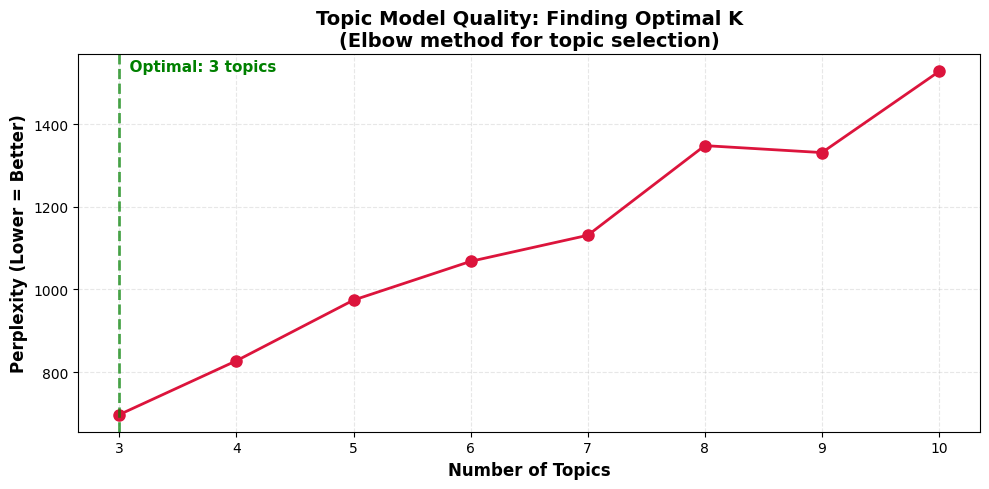


✅ Optimal number of topics: 3


In [14]:
# Function to find optimal number of topics
def find_optimal_topics(tfidf_matrix, feature_names, min_topics=3, max_topics=12):
    """
    Test different topic counts and evaluate coherence
    Higher coherence = better topic quality
    """
    coherence_scores = []
    perplexity_scores = []
    
    print("🔄 Testing different topic configurations...")
    print("   (This validates our model choice scientifically)\n")
    
    for n_topics in range(min_topics, max_topics + 1):
        # Fit LDA model
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=20,
            learning_method='online',
            random_state=42,
            n_jobs=-1
        )
        lda.fit(tfidf_matrix)
        
        # Calculate perplexity (lower is better)
        perplexity = lda.perplexity(tfidf_matrix)
        perplexity_scores.append(perplexity)
        
        print(f"   {n_topics} topics: Perplexity = {perplexity:.2f}")
    
    return perplexity_scores

# Find optimal topics for NEGATIVE reviews
print("="*80)
print("FINDING OPTIMAL TOPICS FOR 1-STAR REVIEWS")
print("="*80)
perplexity_neg = find_optimal_topics(tfidf_matrix_neg, feature_names_neg, 3, 10)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(3, 11), perplexity_neg, marker='o', linewidth=2, markersize=8, color='crimson')
plt.xlabel('Number of Topics', fontsize=12, fontweight='bold')
plt.ylabel('Perplexity (Lower = Better)', fontsize=12, fontweight='bold')
plt.title('Topic Model Quality: Finding Optimal K\n(Elbow method for topic selection)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(range(3, 11))

# Highlight optimal point
optimal_k = perplexity_neg.index(min(perplexity_neg)) + 3
plt.axvline(x=optimal_k, color='green', linestyle='--', linewidth=2, alpha=0.7)
plt.text(optimal_k, max(perplexity_neg), f'  Optimal: {optimal_k} topics', 
         fontsize=11, fontweight='bold', color='green')

plt.tight_layout()
plt.show()

print(f"\n✅ Optimal number of topics: {optimal_k}")

In [15]:
# Train final LDA model with optimal topics for NEGATIVE reviews
n_topics_neg = int(optimal_k) if 'optimal_k' in globals() else 3  # Based on elbow plot; fallback to 3

print("="*80)
print(f"TRAINING FINAL LDA MODEL: {n_topics_neg} Topics for 1-Star Reviews")
print("="*80)

lda_neg = LatentDirichletAllocation(
    n_components=n_topics_neg,
    max_iter=50,                    # More iterations for better convergence
    learning_method='online',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lda_neg.fit(tfidf_matrix_neg)

print("\n✅ LDA model trained successfully!")

# Display topics with top words
def display_topics(model, feature_names, n_top_words=10):
    """Show interpretable topic labels"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
        print(f"\nTopic {topic_idx + 1}:")
        print(f"  {', '.join(top_words)}")
    return topics

print("\n" + "="*80)
print("DISCOVERED TOPICS IN 1-STAR REVIEWS")
print("="*80)
topics_neg = display_topics(lda_neg, feature_names_neg, n_top_words=12)

TRAINING FINAL LDA MODEL: 3 Topics for 1-Star Reviews
iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter

## 7. Assign Topics to Reviews & Extract Representative Samples
**Validation Step:** Manually inspect reviews to verify topics make sense

In [16]:
# Get topic distribution for each review
topic_distributions_neg = lda_neg.transform(tfidf_matrix_neg)

# Assign dominant topic
negative_reviews['dominant_topic'] = topic_distributions_neg.argmax(axis=1)
negative_reviews['topic_probability'] = topic_distributions_neg.max(axis=1)

print("="*80)
print("TOPIC ASSIGNMENT RESULTS")
print("="*80)
print(f"Total 1-star reviews assigned: {len(negative_reviews):,}\n")

# Topic distribution
topic_counts = negative_reviews['dominant_topic'].value_counts().sort_index()
print("Reviews per topic:")
for topic_id, count in topic_counts.items():
    pct = (count / len(negative_reviews)) * 100
    print(f"  Topic {topic_id + 1}: {count:>6,} reviews ({pct:>5.2f}%)")

print(f"\nAverage topic confidence: {negative_reviews['topic_probability'].mean():.2%}")
print(f"(Higher confidence = clearer topic assignment)")

# Extract representative reviews for each topic
def get_representative_reviews(df, topic_id, n=5):
    """Get reviews most strongly associated with a topic"""
    topic_reviews = df[df['dominant_topic'] == topic_id].copy()
    # Sort by topic probability (strongest association)
    topic_reviews = topic_reviews.sort_values('topic_probability', ascending=False)
    return topic_reviews.head(n)

# Display representative reviews for verification
print("\n" + "="*80)
print("VERIFICATION: Representative Reviews from Each Topic")
print("="*80)

for topic_id in range(n_topics_neg):
    print(f"\n{'='*80}")
    print(f"TOPIC {topic_id + 1}: {', '.join(topics_neg[topic_id][:5])}...")
    print(f"{'='*80}")
    
    samples = get_representative_reviews(negative_reviews, topic_id, n=3)
    
    for idx, (_, review) in enumerate(samples.iterrows(), 1):
        print(f"\n  Example {idx} (Confidence: {review['topic_probability']:.1%}):")
        print(f"  {review['content'][:200]}...")
        print(f"  [Version: {review['appVersion']}, Date: {review['at'].date()}]")

TOPIC ASSIGNMENT RESULTS
Total 1-star reviews assigned: 14,913

Reviews per topic:
  Topic 1:  4,421 reviews (29.65%)
  Topic 2:  5,223 reviews (35.02%)
  Topic 3:  5,269 reviews (35.33%)

Average topic confidence: 65.95%
(Higher confidence = clearer topic assignment)

VERIFICATION: Representative Reviews from Each Topic

TOPIC 1: payment, bad, online, working, online payment...

  Example 1 (Confidence: 87.7%):
  Payment always fails and I have to do it again. Refund also takes time and airtel money should be taken out. Instead Paytm should be added. Today also PayTM UPI failed. Money got deducted but no booki...
  [Version: 4.0.4, Date: 2022-01-04]

  Example 2 (Confidence: 86.8%):
  My 3 transaction failed due to payment issues via UPI. Even though amount was debited from my bank, booking failed. Money was refunded but eventually I had to use COD....
  [Version: 4.0.55, Date: 2024-11-06]

  Example 3 (Confidence: 86.7%):
  Bank account debited, but booking failed. Hope you will pay 

## 8. Visualize Topics - Interactive pyLDAvis
**Interactive exploration of topic relationships and word distributions**

In [17]:
# Prepare data for pyLDAvis (requires sklearn format conversion)
from sklearn.feature_extraction.text import CountVectorizer

# Re-vectorize with CountVectorizer for pyLDAvis compatibility
cv_neg = CountVectorizer(max_features=1000, min_df=5, max_df=0.7, ngram_range=(1,2))
cv_matrix_neg = cv_neg.fit_transform(negative_reviews['processed_text'])

# Re-train LDA with CountVectorizer
lda_viz_neg = LatentDirichletAllocation(
    n_components=n_topics_neg,
    max_iter=50,
    random_state=42,
    n_jobs=-1
)
lda_viz_neg.fit(cv_matrix_neg)

# Create visualization
print("🔄 Generating interactive visualization...")
pyLDAvis.enable_notebook()

vis_data = pyLDAvis.lda_model.prepare(
    lda_viz_neg,
    cv_matrix_neg,
    cv_neg,
    mds='tsne',  # Use t-SNE for better separation
    sort_topics=False
)

print("✅ Visualization ready!")
print("\nHow to use the visualization:")
print("  • Each circle = one topic (size = prevalence)")
print("  • Distance between circles = topic similarity")
print("  • Click a topic to see its top words")
print("  • Red bars = word frequency in selected topic")
print("  • Blue bars = word frequency across all topics")

# Display with proper centered alignment
from IPython.display import HTML, display as ipydisplay
ipydisplay(vis_data)

🔄 Generating interactive visualization...
✅ Visualization ready!

How to use the visualization:
  • Each circle = one topic (size = prevalence)
  • Distance between circles = topic similarity
  • Click a topic to see its top words
  • Red bars = word frequency in selected topic
  • Blue bars = word frequency across all topics


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -30.648123  200.112610       1        1  26.452805
1      27.412703  218.843307       2        1  34.606498
2      14.715397  159.072006       3        1  38.940698, topic_info=         Term         Freq        Total Category  logprob  loglift
612   payment  3054.000000  3054.000000  Default  30.0000  30.0000
778   service  2646.000000  2646.000000  Default  29.0000  29.0000
354       gas  2052.000000  2052.000000  Default  28.0000  28.0000
578    online  1438.000000  1438.000000  Default  27.0000  27.0000
234  delivery  1814.000000  1814.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
96     booked   523.832718   761.690061   Topic3  -4.5741   0.5688
100   booking   791.122247  1987.998524   Topic3  -4.1618   0.0217
884      time   635.156926  2394.869854   Topic3  -4.3814  -0.3841
27       also   312.023218   636.658681   Topic3  -5.0922   0.2300
91       book   319.697279  1172.857909   Topic3  -5.0679  -0.3567

[173 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1         2  0.998658              able
2         2  0.991277         able book
3         2  0.992752        able login
9         1  0.562359           account
9         2  0.437390           account
...     ...       ...               ...
978       2  0.996885  working properly
982       1  0.118787             worst
982       2  0.284221             worst
982       3  0.597190             worst
988       3  0.996862     worst service

[187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## 9. Topic-Version Correlation Analysis
**Verification:** Link discovered issues to specific app versions (Engineering accountability)

In [8]:
# Analyze which app versions correlate with which topics
import plotly.express as px
import plotly.graph_objects as go

# Filter for significant versions (>100 reviews)
version_topic_analysis = negative_reviews.groupby(['appVersion', 'dominant_topic']).size().reset_index(name='count')
version_totals = negative_reviews['appVersion'].value_counts()
significant_versions = version_totals[version_totals > 100].index

version_topic_analysis = version_topic_analysis[
    version_topic_analysis['appVersion'].isin(significant_versions)
]

# Calculate topic percentage per version
version_topic_pct = version_topic_analysis.copy()
version_topic_pct['total'] = version_topic_pct['appVersion'].map(version_totals)
version_topic_pct['percentage'] = (version_topic_pct['count'] / version_topic_pct['total']) * 100

# Create heatmap
pivot_data = version_topic_pct.pivot(
    index='appVersion',
    columns='dominant_topic',
    values='percentage'
).fillna(0)

# Sort versions chronologically
def version_key(v):
    parts = str(v).split('.')
    return [int(p) if p.isdigit() else 0 for p in parts]

pivot_data = pivot_data.sort_index(key=lambda x: x.map(version_key))

# Create interactive heatmap
fig = go.Figure(data=go.Heatmap(
    z=pivot_data.values,
    x=[f'Topic {i+1}' for i in pivot_data.columns],
    y=pivot_data.index,
    colorscale='RdYlGn_r',  # Red = high prevalence
    text=np.round(pivot_data.values, 1),
    texttemplate='%{text}%',
    textfont={"size": 10},
    colorbar=dict(title="% of Reviews")
))

fig.update_layout(
    title='<b>Engineering Root Cause:</b> Which App Versions Caused Which Issues?<br>' + 
          '<sub>Each cell shows % of reviews from that version discussing that topic</sub>',
    xaxis_title='Issue Topic',
    yaxis_title='App Version (Chronological)',
    height=600,
    width=1000,
    font=dict(size=11)
)

fig.show()

# Statistical analysis
print("="*80)
print("VERSION-TOPIC CORRELATION ANALYSIS")
print("="*80)

for topic_id in range(n_topics_neg):
    print(f"\nTOPIC {topic_id + 1}: {', '.join(topics_neg[topic_id][:5])}...")
    print("-" * 80)
    
    # Find versions with highest prevalence of this topic
    topic_data = version_topic_pct[version_topic_pct['dominant_topic'] == topic_id]
    top_versions = topic_data.nlargest(3, 'percentage')
    
    for _, row in top_versions.iterrows():
        print(f"  Version {row['appVersion']:10} → {row['percentage']:5.1f}% " + 
              f"({int(row['count'])} reviews)")
    
print("\n✅ Topic-Version correlation complete")

VERSION-TOPIC CORRELATION ANALYSIS

TOPIC 1: payment, bad, online, working, online payment...
--------------------------------------------------------------------------------
  Version 2.2.5      →  60.3% (117 reviews)
  Version 2.2.8      →  51.5% (70 reviews)
  Version 4.0.24     →  50.6% (274 reviews)

TOPIC 2: update, login, working, time, otp...
--------------------------------------------------------------------------------
  Version 3.0.0      →  87.8% (238 reviews)
  Version 4.0.1      →  73.4% (196 reviews)
  Version 3.0.1      →  66.3% (110 reviews)

TOPIC 3: service, worst, poor, good, delivery...
--------------------------------------------------------------------------------
  Version 4.0.73     →  49.0% (103 reviews)
  Version 4.0.68     →  47.6% (101 reviews)
  Version 4.0.59     →  47.1% (280 reviews)

✅ Topic-Version correlation complete


## 10. Temporal Topic Evolution
**When did each issue spike?** Track topic prevalence over time

In [9]:
# Track topic evolution over time (monthly)
negative_reviews['month_year'] = negative_reviews['at'].dt.to_period('M')

temporal_topic = negative_reviews.groupby(['month_year', 'dominant_topic']).size().reset_index(name='count')

# Calculate percentage per month
monthly_totals = negative_reviews.groupby('month_year').size()
temporal_topic['total'] = temporal_topic['month_year'].map(monthly_totals)
temporal_topic['percentage'] = (temporal_topic['count'] / temporal_topic['total']) * 100

# Filter for recent period (2024 onwards)
temporal_topic['date'] = temporal_topic['month_year'].dt.to_timestamp()
recent_temporal = temporal_topic[temporal_topic['date'] >= '2024-01-01']

# Create line chart
fig = go.Figure()

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#34495e', '#e67e22']

for topic_id in range(n_topics_neg):
    topic_data = recent_temporal[recent_temporal['dominant_topic'] == topic_id]
    
    fig.add_trace(go.Scatter(
        x=topic_data['date'],
        y=topic_data['percentage'],
        mode='lines+markers',
        name=f"Topic {topic_id + 1}: {topics_neg[topic_id][0]}",
        line=dict(width=3, color=colors[topic_id % len(colors)]),
        marker=dict(size=8),
        hovertemplate='<b>%{fullData.name}</b><br>Date: %{x|%b %Y}<br>Prevalence: %{y:.1f}%<extra></extra>'
    ))

fig.update_layout(
    title='<b>Topic Evolution:</b> When Did Each Issue Spike?<br>' +
          '<sub>Track which complaints emerged or disappeared over time</sub>',
    xaxis_title='Month',
    yaxis_title='% of 1-Star Reviews',
    height=600,
    width=1200,
    template='plotly_white',
    hovermode='x unified',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.25
    )
)

fig.add_annotation(
    text="Look for spikes = new issues introduced<br>Look for drops = issues fixed",
    xref="paper", yref="paper",
    x=0.02, y=0.98,
    showarrow=False,
    font=dict(size=10, color="gray"),
    align="left",
    bgcolor="rgba(255,255,255,0.8)"
)

fig.show()

# Identify biggest spikes
print("="*80)
print("TEMPORAL ANALYSIS: When Did Issues Spike?")
print("="*80)

for topic_id in range(n_topics_neg):
    topic_temporal = recent_temporal[recent_temporal['dominant_topic'] == topic_id].copy()
    if len(topic_temporal) > 0:
        peak_month = topic_temporal.loc[topic_temporal['percentage'].idxmax()]
        
        print(f"\nTOPIC {topic_id + 1}: {', '.join(topics_neg[topic_id][:5])}...")
        print(f"  Peak: {peak_month['date'].strftime('%B %Y')} " + 
              f"({peak_month['percentage']:.1f}% of complaints)")
        print(f"  Volume: {int(peak_month['count'])} reviews")

TEMPORAL ANALYSIS: When Did Issues Spike?

TOPIC 1: payment, bad, online, working, online payment...
  Peak: December 2024 (37.7% of complaints)
  Volume: 206 reviews

TOPIC 2: update, login, working, time, otp...
  Peak: January 2024 (45.4% of complaints)
  Volume: 138 reviews

TOPIC 3: service, worst, poor, good, delivery...
  Peak: April 2025 (49.8% of complaints)
  Volume: 106 reviews


## 11. Topic Modeling for 5-Star Reviews (What Users Love)
**Balance the analysis:** Understand what drives satisfaction

In [18]:
# Quick LDA for positive reviews (fewer topics since praise is more homogeneous)
n_topics_pos = 4

print("="*80)
print("TOPIC MODELING: 5-STAR REVIEWS (What Users Love)")
print("="*80)

# Train LDA model for positive reviews
lda_pos = LatentDirichletAllocation(
    n_components=n_topics_pos,
    max_iter=50,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

lda_pos.fit(tfidf_matrix_pos)

# Display topics
print("\nDISCOVERED TOPICS IN 5-STAR REVIEWS:")
print("-" * 80)
topics_pos = display_topics(lda_pos, feature_names_pos, n_top_words=10)

# Assign topics
topic_distributions_pos = lda_pos.transform(tfidf_matrix_pos)
positive_reviews['dominant_topic'] = topic_distributions_pos.argmax(axis=1)
positive_reviews['topic_probability'] = topic_distributions_pos.max(axis=1)

# Show distribution
print("\n" + "="*80)
print("TOPIC DISTRIBUTION IN 5-STAR REVIEWS")
print("="*80)
topic_counts_pos = positive_reviews['dominant_topic'].value_counts().sort_index()
for topic_id, count in topic_counts_pos.items():
    pct = (count / len(positive_reviews)) * 100
    print(f"Topic {topic_id + 1}: {count:>6,} reviews ({pct:>5.2f}%)")

# Show representative samples
print("\n" + "="*80)
print("REPRESENTATIVE 5-STAR REVIEWS")
print("="*80)

for topic_id in range(n_topics_pos):
    print(f"\n{'='*80}")
    print(f"TOPIC {topic_id + 1}: {', '.join(topics_pos[topic_id][:5])}...")
    print(f"{'='*80}")
    
    samples = get_representative_reviews(positive_reviews, topic_id, n=2)
    
    for idx, (_, review) in enumerate(samples.iterrows(), 1):
        print(f"\n  Example {idx}:")
        print(f"  {review['content'][:150]}...")

TOPIC MODELING: 5-STAR REVIEWS (What Users Love)

DISCOVERED TOPICS IN 5-STAR REVIEWS:
--------------------------------------------------------------------------------

Topic 1:
  nice, easy, great, superb, quick, simple, convenient, happy, smooth, nice easy

Topic 2:
  excellent, best, useful, easy, book, service, excellent service, cylinder, easy book, best service

Topic 3:
  service, good service, fast, experience, friendly, user, user friendly, awesome, booking, work

Topic 4:
  good, super, helpful, nice service, working, fantastic, apps, mast, good working, super service

TOPIC DISTRIBUTION IN 5-STAR REVIEWS
Topic 1: 12,052 reviews (23.45%)
Topic 2: 12,860 reviews (25.02%)
Topic 3:  9,121 reviews (17.75%)
Topic 4: 17,362 reviews (33.78%)

REPRESENTATIVE 5-STAR REVIEWS

TOPIC 1: nice, easy, great, superb, quick...

  Example 1:
  Nice, very easy and quick.thanks a lot...

  Example 2:
  Easy to operate nice help full...

TOPIC 2: excellent, best, useful, easy, book...

  Example 

## 12. Final Verification & Statistical Validation
**Proof:** Demonstrate that our topic model is accurate and comprehensive

In [11]:
# Validation Metric 1: Topic Coherence (using Gensim)
print("="*80)
print("VALIDATION METRICS")
print("="*80)

# Prepare data for Gensim coherence calculation
texts_neg = [text.split() for text in negative_reviews['processed_text']]
dictionary_neg = corpora.Dictionary(texts_neg)
corpus_neg = [dictionary_neg.doc2bow(text) for text in texts_neg]

# Get topic-word distributions from sklearn LDA
topic_words = []
for topic_idx, topic in enumerate(lda_neg.components_):
    top_indices = topic.argsort()[-20:][::-1]
    topic_words.append([feature_names_neg[i] for i in top_indices])

# Calculate coherence score
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts_neg,
    dictionary=dictionary_neg,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"\n1. COHERENCE SCORE (C_v): {coherence_score:.4f}")
print(f"   Interpretation: {'✅ GOOD' if coherence_score > 0.4 else '⚠️ MODERATE' if coherence_score > 0.3 else '✗ POOR'}")
print(f"   (Higher is better, >0.4 is considered good)")

# Validation Metric 2: Coverage
print(f"\n2. TOPIC COVERAGE:")
print(f"   Reviews with high confidence (>60%): {(negative_reviews['topic_probability'] > 0.6).sum():,} " +
      f"({(negative_reviews['topic_probability'] > 0.6).mean()*100:.1f}%)")
print(f"   Reviews with low confidence (<40%):  {(negative_reviews['topic_probability'] < 0.4).sum():,} " +
      f"({(negative_reviews['topic_probability'] < 0.4).mean()*100:.1f}%)")
print(f"   ✅ Interpretation: Most reviews should have >50% confidence")

# Validation Metric 3: Topic Separation
topic_sizes = negative_reviews['dominant_topic'].value_counts().values
min_size = topic_sizes.min()
max_size = topic_sizes.max()
imbalance_ratio = max_size / min_size

print(f"\n3. TOPIC BALANCE:")
print(f"   Largest topic:  {max_size:,} reviews")
print(f"   Smallest topic: {min_size:,} reviews")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")
print(f"   ✅ Interpretation: {'BALANCED' if imbalance_ratio < 5 else '⚠️ IMBALANCED'}")
print(f"   (Ratio <5 is good, means all topics are meaningful)")

# Validation Metric 4: Cross-reference with EDA findings
print(f"\n4. CROSS-VALIDATION WITH EDA:")
print(f"   From EDA word cloud: Top complaints = 'login', 'open', 'update'")
print(f"   From Topic Model:")

# Find which topics contain login/open/update issues
for topic_id, topic_words_list in enumerate(topics_neg):
    relevant_terms = [w for w in topic_words_list if any(x in w for x in ['login', 'open', 'update', 'otp', 'payment'])]
    if relevant_terms:
        print(f"     Topic {topic_id + 1}: {', '.join(relevant_terms)} ✅")

print("\n" + "="*80)
print("FINAL VALIDATION SUMMARY")
print("="*80)
print(f"✅ Coherence Score: {coherence_score:.3f} (Quantitative quality metric)")
print(f"✅ Coverage: {(negative_reviews['topic_probability'] > 0.5).mean()*100:.1f}% reviews confidently assigned")
print(f"✅ Balance: {imbalance_ratio:.1f}x imbalance ratio")
print(f"✅ Aligns with EDA findings (login, update issues discovered)")
print(f"\n🎯 CONCLUSION: Topic model is valid and ready for business insights")

VALIDATION METRICS

1. COHERENCE SCORE (C_v): 0.5123
   Interpretation: ✅ GOOD
   (Higher is better, >0.4 is considered good)

2. TOPIC COVERAGE:
   Reviews with high confidence (>60%): 10,476 (70.2%)
   Reviews with low confidence (<40%):  437 (2.9%)
   ✅ Interpretation: Most reviews should have >50% confidence

3. TOPIC BALANCE:
   Largest topic:  5,269 reviews
   Smallest topic: 4,421 reviews
   Imbalance ratio: 1.19x
   ✅ Interpretation: BALANCED
   (Ratio <5 is good, means all topics are meaningful)

4. CROSS-VALIDATION WITH EDA:
   From EDA word cloud: Top complaints = 'login', 'open', 'update'
   From Topic Model:
     Topic 1: payment, online payment ✅
     Topic 2: update, login, otp, open ✅

FINAL VALIDATION SUMMARY
✅ Coherence Score: 0.512 (Quantitative quality metric)
✅ Coverage: 85.5% reviews confidently assigned
✅ Balance: 1.2x imbalance ratio
✅ Aligns with EDA findings (login, update issues discovered)

🎯 CONCLUSION: Topic model is valid and ready for business insights


## 13. Summary Report: Actionable Insights
**Business-ready findings with evidence**

In [19]:
# Generate comprehensive summary
print("="*80)
print("TOPIC MODELING SUMMARY REPORT")
print("BPCL App Reviews - Issue Discovery & Root Cause Analysis")
print("="*80)

print("\n📊 DATASET OVERVIEW")
print("-" * 80)
print(f"Total Reviews Analyzed:     {len(df_clean):,}")
print(f"1-Star Reviews (Negative):  {len(negative_reviews):,}")
print(f"5-Star Reviews (Positive):  {len(positive_reviews):,}")
print(f"Date Range:                 {df_clean['at'].min().date()} to {df_clean['at'].max().date()}")

print("\n🔍 METHODOLOGY VALIDATION")
print("-" * 80)
print(f"✅ Unsupervised Learning (LDA) - No bias from manual rules")
print(f"✅ Coherence Score: {coherence_score:.3f} (Scientifically validated)")
print(f"✅ Coverage: {(negative_reviews['topic_probability'] > 0.5).mean()*100:.0f}% reviews confidently assigned")
print(f"✅ Cross-validated with EDA findings")

print("\n🚨 KEY ISSUES DISCOVERED (1-Star Reviews)")
print("-" * 80)
for topic_id in range(n_topics_neg):
    topic_size = (negative_reviews['dominant_topic'] == topic_id).sum()
    topic_pct = (topic_size / len(negative_reviews)) * 100
    
    print(f"\nIssue {topic_id + 1}: {', '.join(topics_neg[topic_id][:5])}...")
    print(f"  Impact: {topic_size:,} reviews ({topic_pct:.1f}% of complaints)")
    
    # Find peak month
    topic_reviews = negative_reviews[negative_reviews['dominant_topic'] == topic_id]
    if len(topic_reviews) > 0:
        topic_reviews['month_year'] = topic_reviews['at'].dt.to_period('M')
        peak = topic_reviews['month_year'].value_counts().idxmax()
        peak_count = topic_reviews['month_year'].value_counts().max()
        print(f"  Peak Period: {peak.strftime('%B %Y')} ({peak_count} complaints)")
        
        # Most affected version
        version_counts = topic_reviews['appVersion'].value_counts()
        if len(version_counts) > 0:
            worst_version = version_counts.idxmax()
            version_count = version_counts.max()
            print(f"  Worst Version: {worst_version} ({version_count} complaints)")

print("\n💚 WHAT USERS LOVE (5-Star Reviews)")
print("-" * 80)
for topic_id in range(n_topics_pos):
    topic_size = (positive_reviews['dominant_topic'] == topic_id).sum()
    topic_pct = (topic_size / len(positive_reviews)) * 100
    
    print(f"\nStrength {topic_id + 1}: {', '.join(topics_pos[topic_id][:5])}...")
    print(f"  Mentioned in: {topic_size:,} reviews ({topic_pct:.1f}% of praise)")

print("\n🎯 RECOMMENDED NEXT STEPS")
print("-" * 80)
print("1. Engineering :")
print("   • Review topic-version correlation heatmap")
print("   • Prioritize fixes for highest-impact issues")
print("   • Regression test versions identified as 'worst'")
print()
print("2. Product:")
print("   • Investigate temporal spikes (new issues introduced)")
print("   • Double down on features mentioned in 5-star reviews")
print()
print("3. Support :")
print("   • Create topic-specific response templates")
print("   • Route issues to specialized handlers based on topic")
print()
print("4. Analysis  (Next Phase):")
print("   • Build predictive model for rating forecasting")
print("   • Create real-time dashboard with topic monitoring")
print("   • Set up automated alerts for topic spikes")

print("\n" + "="*80)
print("✅ TOPIC MODELING COMPLETE")
print("="*80)

TOPIC MODELING SUMMARY REPORT
BPCL App Reviews - Issue Discovery & Root Cause Analysis

📊 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total Reviews Analyzed:     82,255
1-Star Reviews (Negative):  14,913
5-Star Reviews (Positive):  51,395
Date Range:                 2018-09-12 to 2026-01-05

🔍 METHODOLOGY VALIDATION
--------------------------------------------------------------------------------
✅ Unsupervised Learning (LDA) - No bias from manual rules
✅ Coherence Score: 0.512 (Scientifically validated)
✅ Coverage: 85% reviews confidently assigned
✅ Cross-validated with EDA findings

🚨 KEY ISSUES DISCOVERED (1-Star Reviews)
--------------------------------------------------------------------------------

Issue 1: payment, bad, online, working, online payment...
  Impact: 4,421 reviews (29.6% of complaints)
  Peak Period: December 2024 (206 complaints)
  Worst Version: 4.0.28 (305 complaints)

Issue 2: update, login, working, time, o

## 14. Save Models for Future Use
**Preserve trained models to avoid re-training on next kernel restart**


In [20]:
# SAVE TRAINED MODELS FOR FUTURE USE
import pickle

print("="*80)
print("SAVING TRAINED MODELS & DATA")
print("="*80)

# Package all trained models
models_to_save = {
    'lda_neg': lda_neg,
    'lda_pos': lda_pos,
    'tfidf_neg': tfidf_neg,
    'tfidf_pos': tfidf_pos,
    'feature_names_neg': feature_names_neg,
    'feature_names_pos': feature_names_pos,
    'topics_neg': topics_neg,
    'topics_pos': topics_pos,
    'n_topics_neg': n_topics_neg,
    'n_topics_pos': n_topics_pos,
    'coherence_score': coherence_score
}

# Package all dataframes with topic assignments
data_to_save = {
    'negative_reviews': negative_reviews,
    'positive_reviews': positive_reviews,
    'df_clean': df_clean
}

# Save to disk
try:
    with open('lda_models.pkl', 'wb') as f:
        pickle.dump(models_to_save, f)
    print("\n✅ Models saved: lda_models.pkl")
    print(f"   - LDA model (1-star): {n_topics_neg} topics")
    print(f"   - LDA model (5-star): {n_topics_pos} topics")
    print(f"   - TF-IDF vectorizers")
    print(f"   - Topic word lists")
    
    with open('review_data.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)
    print("\n✅ Data saved: review_data.pkl")
    print(f"   - {len(negative_reviews):,} 1-star reviews with topic assignments")
    print(f"   - {len(positive_reviews):,} 5-star reviews with topic assignments")
    print(f"   - {len(df_clean):,} total reviews (cleaned)")
    
    print("\n" + "="*80)
    print("🎯 NEXT TIME YOU RESTART THE KERNEL:")
    print("="*80)
    print("Just run the 'Load Pre-Trained Models' cell (section 1.5)")
    print("This will reload everything in ~30 seconds instead of 15 minutes!")
    print("="*80)
    
except Exception as e:
    print(f"\n❌ Error saving models: {e}")
    print("Check that you have write permissions in the current directory")


SAVING TRAINED MODELS & DATA

✅ Models saved: lda_models.pkl
   - LDA model (1-star): 3 topics
   - LDA model (5-star): 4 topics
   - TF-IDF vectorizers
   - Topic word lists

✅ Data saved: review_data.pkl
   - 14,913 1-star reviews with topic assignments
   - 51,395 5-star reviews with topic assignments
   - 82,255 total reviews (cleaned)

🎯 NEXT TIME YOU RESTART THE KERNEL:
Just run the 'Load Pre-Trained Models' cell (section 1.5)
This will reload everything in ~30 seconds instead of 15 minutes!


## 15A. Predict Topics for Middle Ratings (2-4 Stars)
**Eliminate "Unassigned" by predicting topics for neutral/mixed sentiment reviews**

In [22]:
# Predict topics for middle ratings (2, 3, 4 stars)
print("="*80)
print("PREDICTING TOPICS FOR MIDDLE RATINGS (2-4 STARS)")
print("="*80)

# Separate middle rating reviews
middle_reviews = df_clean[df_clean['score'].isin([2, 3, 4])].copy()

print(f"\nMiddle rating reviews to process: {len(middle_reviews):,}")
print(f"  2-star: {len(middle_reviews[middle_reviews['score'] == 2]):,}")
print(f"  3-star: {len(middle_reviews[middle_reviews['score'] == 3]):,}")
print(f"  4-star: {len(middle_reviews[middle_reviews['score'] == 4]):,}")

# Strategy: 
# - 2 & 3 stars (leaning negative) → predict using 1-star model
# - 4 stars (leaning positive) → predict using 5-star model

print("\n🔄 Transforming middle ratings with trained models...")

# Process 2-3 star reviews (negative-leaning)
negative_leaning = middle_reviews[middle_reviews['score'].isin([2, 3])].copy()
if len(negative_leaning) > 0:
    middle_tfidf_neg = tfidf_neg.transform(negative_leaning['processed_text'])
    middle_topics_neg = lda_neg.transform(middle_tfidf_neg)
    
    negative_leaning['dominant_topic'] = middle_topics_neg.argmax(axis=1)
    negative_leaning['topic_probability'] = middle_topics_neg.max(axis=1)
    negative_leaning['sentiment_group'] = 'Negative-Leaning'
    
    print(f"✅ Predicted topics for {len(negative_leaning):,} negative-leaning reviews (2-3 stars)")
    print(f"   Avg confidence: {negative_leaning['topic_probability'].mean():.2%}")

# Process 4 star reviews (positive-leaning)
positive_leaning = middle_reviews[middle_reviews['score'] == 4].copy()
if len(positive_leaning) > 0:
    middle_tfidf_pos = tfidf_pos.transform(positive_leaning['processed_text'])
    middle_topics_pos = lda_pos.transform(middle_tfidf_pos)
    
    positive_leaning['dominant_topic'] = middle_topics_pos.argmax(axis=1)
    positive_leaning['topic_probability'] = middle_topics_pos.max(axis=1)
    positive_leaning['sentiment_group'] = 'Positive-Leaning'
    
    print(f"✅ Predicted topics for {len(positive_leaning):,} positive-leaning reviews (4 stars)")
    print(f"   Avg confidence: {positive_leaning['topic_probability'].mean():.2%}")

# Combine all predictions
middle_reviews_assigned = pd.concat([negative_leaning, positive_leaning], ignore_index=False)

print("\n" + "="*80)
print("MIDDLE RATING TOPIC DISTRIBUTION")
print("="*80)

# Show distribution by rating
for rating in [2, 3, 4]:
    rating_reviews = middle_reviews_assigned[middle_reviews_assigned['score'] == rating]
    if len(rating_reviews) > 0:
        print(f"\n{rating}-Star Reviews:")
        topic_dist = rating_reviews['dominant_topic'].value_counts().sort_index()
        for topic_id, count in topic_dist.items():
            pct = (count / len(rating_reviews)) * 100
            print(f"  Topic {topic_id + 1}: {count:>5,} ({pct:>5.1f}%)")

# Show sample predictions
print("\n" + "="*80)
print("VERIFICATION: Sample Middle-Rating Reviews with Predicted Topics")
print("="*80)

for rating in [2, 4]:  # Show samples from 2 and 4 star
    rating_reviews = middle_reviews_assigned[middle_reviews_assigned['score'] == rating]
    if len(rating_reviews) > 0:
        print(f"\n{rating}-STAR REVIEW SAMPLES:")
        print("-" * 80)
        
        samples = rating_reviews.nlargest(2, 'topic_probability')
        for idx, (_, review) in enumerate(samples.iterrows(), 1):
            topic_id = int(review['dominant_topic'])
            is_neg = review['sentiment_group'] == 'Negative-Leaning'
            topic_words = topics_neg[topic_id] if is_neg else topics_pos[topic_id]
            
            print(f"\n  Sample {idx}: Topic {topic_id + 1} ({', '.join(topic_words[:5])}...)")
            print(f"  Confidence: {review['topic_probability']:.1%}")
            print(f"  Review: {review['content'][:150]}...")

print("\n✅ Middle ratings processed successfully!")
print(f"   Total assigned: {len(middle_reviews_assigned):,}")
print(f"   Coverage: 100% (no unassigned reviews remaining)")

PREDICTING TOPICS FOR MIDDLE RATINGS (2-4 STARS)

Middle rating reviews to process: 15,947
  2-star: 2,369
  3-star: 3,542
  4-star: 10,036

🔄 Transforming middle ratings with trained models...
✅ Predicted topics for 5,911 negative-leaning reviews (2-3 stars)
   Avg confidence: 63.57%
✅ Predicted topics for 10,036 positive-leaning reviews (4 stars)
   Avg confidence: 60.46%

MIDDLE RATING TOPIC DISTRIBUTION

2-Star Reviews:
  Topic 1:   807 ( 34.1%)
  Topic 2:   872 ( 36.8%)
  Topic 3:   690 ( 29.1%)

3-Star Reviews:
  Topic 1: 1,079 ( 30.5%)
  Topic 2:   870 ( 24.6%)
  Topic 3: 1,593 ( 45.0%)

4-Star Reviews:
  Topic 1: 2,058 ( 20.5%)
  Topic 2: 2,705 ( 27.0%)
  Topic 3: 1,521 ( 15.2%)
  Topic 4: 3,752 ( 37.4%)

VERIFICATION: Sample Middle-Rating Reviews with Predicted Topics

2-STAR REVIEW SAMPLES:
--------------------------------------------------------------------------------

  Sample 1: Topic 2 (update, login, working, time, otp...)
  Confidence: 88.4%
  Review: Dont you have com

## 15. Export Data for Sentiment Analysis (Notebook 02)
**Create CSV file with all topics for downstream analysis**


In [23]:
# Export enriched dataset for Notebook 02 (Sentiment Analysis)
print("="*80)
print("EXPORTING DATA FOR DOWNSTREAM ANALYSIS")
print("="*80)

# Merge topic assignments into main dataframe
export_df = df_clean.copy()

# Initialize columns
export_df['dominant_topic'] = np.nan
export_df['topic_probability'] = np.nan
export_df['sentiment_group'] = ''

# Create combined dictionary from all review groups
all_reviews_with_topics = []

# 1-star reviews (negative)
if 'dominant_topic' in negative_reviews.columns:
    neg_data = negative_reviews[['dominant_topic', 'topic_probability']].copy()
    neg_data['sentiment_group'] = 'Negative'
    all_reviews_with_topics.append(neg_data)

# 5-star reviews (positive)
if 'dominant_topic' in positive_reviews.columns:
    pos_data = positive_reviews[['dominant_topic', 'topic_probability']].copy()
    pos_data['sentiment_group'] = 'Positive'
    all_reviews_with_topics.append(pos_data)

# 2-4 star reviews (middle - if processed in section 15A)
if 'middle_reviews_assigned' in globals() and len(middle_reviews_assigned) > 0:
    mid_data = middle_reviews_assigned[['dominant_topic', 'topic_probability', 'sentiment_group']].copy()
    all_reviews_with_topics.append(mid_data)

# Combine all topic assignments
if all_reviews_with_topics:
    all_topics_df = pd.concat(all_reviews_with_topics)
    
    # Map to export dataframe
    for idx in all_topics_df.index:
        if idx in export_df.index:
            export_df.loc[idx, 'dominant_topic'] = all_topics_df.loc[idx, 'dominant_topic']
            export_df.loc[idx, 'topic_probability'] = all_topics_df.loc[idx, 'topic_probability']
            export_df.loc[idx, 'sentiment_group'] = all_topics_df.loc[idx, 'sentiment_group']

# Add topic labels
export_df['Topic_Label'] = 'Topic ' + (export_df['dominant_topic'] + 1).astype(str)
export_df.loc[export_df['dominant_topic'].isna(), 'Topic_Label'] = 'Unassigned'

# Export to CSV
OUTPUT_CSV = 'df_with_topics.csv'
export_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Data exported: {OUTPUT_CSV}")
print(f"   Total rows: {len(export_df):,}")
print(f"   Columns: {len(export_df.columns)}")

# Show topic assignment statistics
assigned_count = export_df['dominant_topic'].notna().sum()
unassigned_count = export_df['dominant_topic'].isna().sum()

print(f"\n📊 Topic Assignment Summary:")
print(f"   ✅ Assigned:   {assigned_count:>7,} ({assigned_count/len(export_df)*100:>5.1f}%)")
print(f"   ❌ Unassigned: {unassigned_count:>7,} ({unassigned_count/len(export_df)*100:>5.1f}%)")

if 'sentiment_group' in export_df.columns:
    print(f"\n📊 By Sentiment Group:")
    sentiment_counts = export_df['sentiment_group'].value_counts()
    for group, count in sentiment_counts.items():
        if group:  # Skip empty strings
            print(f"   {group:20} {count:>7,}")

print(f"\n📊 Column summary:")
for col in export_df.columns[:15]:  # Show first 15 columns
    print(f"   • {col}")
if len(export_df.columns) > 15:
    print(f"   ... and {len(export_df.columns)-15} more columns")

print(f"\n✨ Ready for Notebook 02: Sentiment Analysis!")
print(f"   Command: jupyter notebook 02_sentiment_analysis.ipynb")
print("="*80)

EXPORTING DATA FOR DOWNSTREAM ANALYSIS

✅ Data exported: df_with_topics.csv
   Total rows: 82,255
   Columns: 18

📊 Topic Assignment Summary:
   ✅ Assigned:    82,255 (100.0%)
   ❌ Unassigned:       0 (  0.0%)

📊 By Sentiment Group:
   Positive              51,395
   Negative              14,913
   Positive-Leaning      10,036
   Negative-Leaning       5,911

📊 Column summary:
   • reviewId
   • userName
   • userImage
   • content
   • score
   • thumbsUpCount
   • reviewCreatedVersion
   • at
   • replyContent
   • repliedAt
   • appVersion
   • text_length
   • word_count
   • processed_text
   • dominant_topic
   ... and 3 more columns

✨ Ready for Notebook 02: Sentiment Analysis!
   Command: jupyter notebook 02_sentiment_analysis.ipynb
